In [1]:
import hydra
import torch

from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra import compose, initialize


import sys

sys.path.append("../")

from complex_neural_source_localization.dataset import DCASE2019Task3Dataset, load_multichannel_wav, create_dataloaders
from complex_neural_source_localization.model import DOACNet
from complex_neural_source_localization.utils.model_visualization import (
    plot_multichannel_spectrogram,
    plot_model_output,
    plot_real_feature_maps
)
from complex_neural_source_localization.trainer import DOACNetLightniningModule

GlobalHydra.instance().clear()
initialize(config_path="../config")
config = compose("config")

MODEL_CHECKPOINT_PATH = "/Users/ezajlerg/datasets/complex_valued_source_localization/weights_4.ckpt"

In [2]:
dataset = create_dataloaders(config)[0]

model = DOACNetLightniningModule(config)
model.model.track_feature_maps()
model.eval()
checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"])

batch = next(iter(dataset))[0]
model_output = model(batch)
feature_maps = model.model.feature_maps


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
      

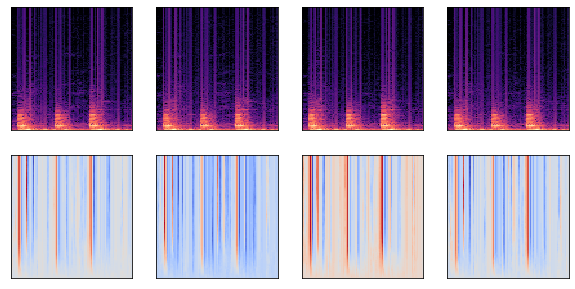

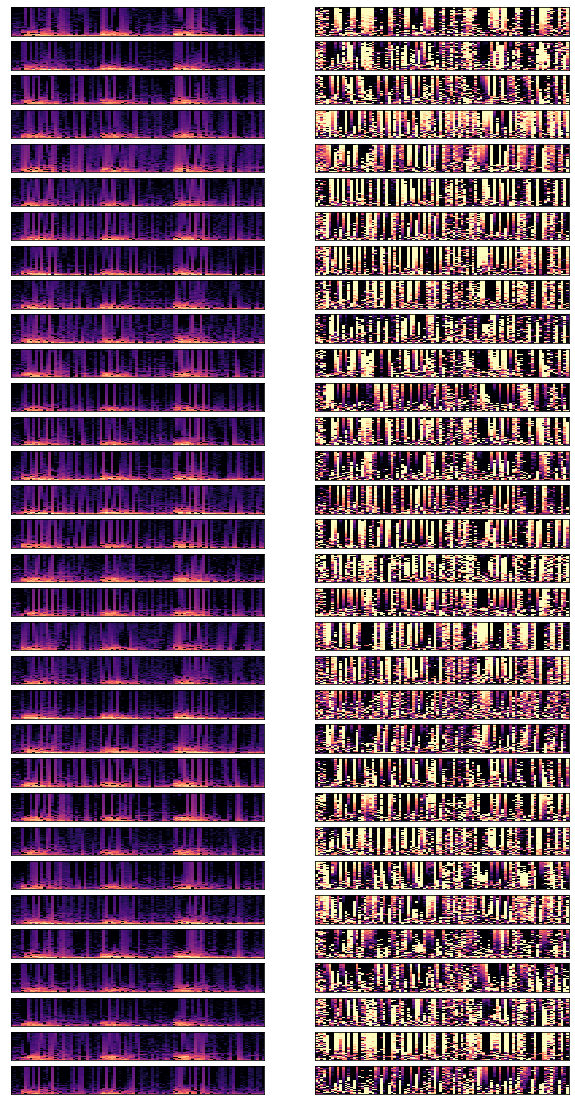

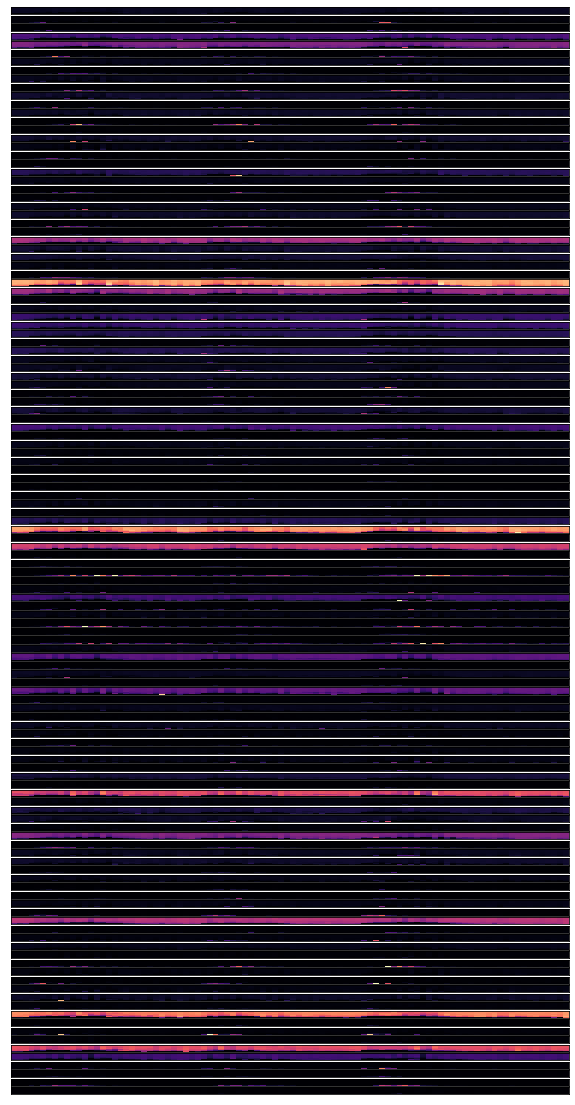

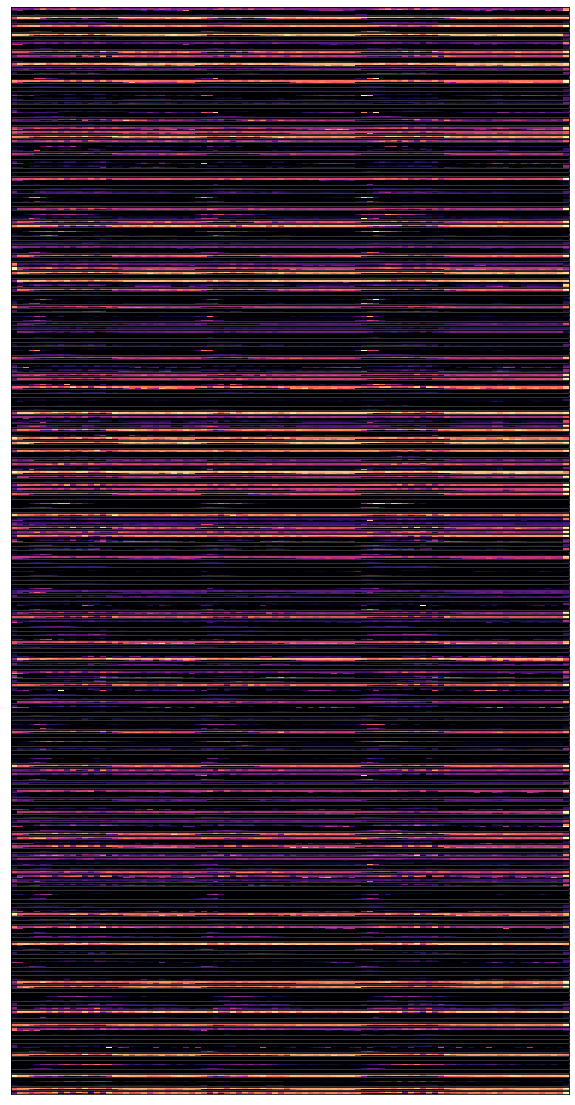

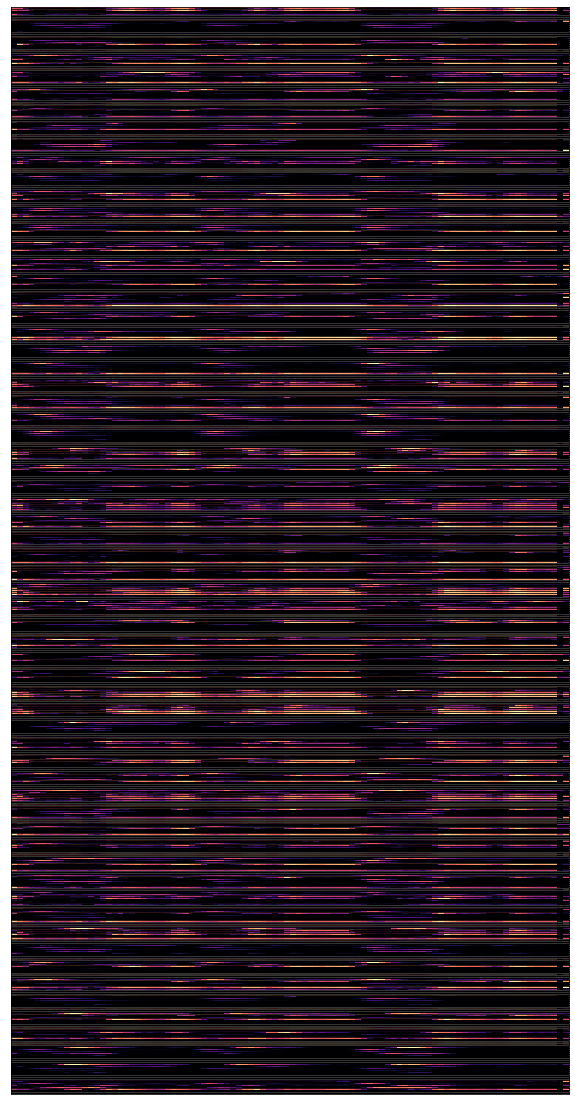

In [10]:
feature_maps = model.model.feature_maps

batch_idx = 3
plot_multichannel_spectrogram(feature_maps["stft"][batch_idx], close=False)
plot_multichannel_spectrogram(feature_maps["conv_0"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 20), unwrap=True)
plot_real_feature_maps(feature_maps["conv_1"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 20))
plot_real_feature_maps(feature_maps["conv_2"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 20))
plot_real_feature_maps(feature_maps["conv_3"][batch_idx].transpose(-1, -2), close=False, mode="row",
                figsize=(10, 20))

In [4]:
feature_maps["rnn"].shape

torch.Size([32, 94, 512])